# Промышленность

## Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.


### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


### План работы

1. Обзор данных, первичный анализ. Предобработка данных: изменение типов данных; определение неинформативных данных, выбросов и аномалий; определить и использовать номера партий, у которых есть замеры по температуре. 
2. Подготовка признаков. Составление единой таблицы со всеми данными для модели.Разбиение на обучающую и тестовую выборки. Выделение целевого признака как последний замер в серии замеров. 
3. Выбор моделей. Использование и обучение регрессионных моделей, например, CatBoostRegressor, LGBMRegressor и т.д. Используем cv для кросс-валидации.
4. Оценка эффективности моделей на тестовой выборке.

## Обзор данных

Импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
import time

Выгрузим предоставленные данные:

In [3]:
try:
    data_arc = pd.read_csv('/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/final_steel/data_wire_time.csv')
except:    
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [4]:
def show_rows_uniq(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].sort_values().unique())

### Данные об электродах

Получим подробню информацию:

In [5]:
display(data_arc.head(10))
print(data_arc.info(),"\n")
print(data_arc.isna().sum(axis=0),"\n")
data_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None 

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64 



,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [6]:
show_rows_uniq(data_arc)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Начало нагрева дугой
['2019-05-03 11:02:14' '2019-05-03 11:07:28' '2019-05-03 11:11:44' ...
 '2019-09-01 04:16:41' '2019-09-01 04:31:51' '2019-09-01 04:34:47']
Уникальные значения столбца Конец нагрева дугой
['2019-05-03 11:06:02' '2019-05-03 11:10:33' '2019-05-03 11:14:36' ...
 '2019-09-01 04:19:45' '2019-09-01 04:32:48' '2019-09-01 04:36:08']
Уникальные значения столбца Активная мощность
[0.03000194 0.03018816 0.0301905  ... 3.15076178 3.15627646 3.73159611]
Уникальные значения столбца Реактивная мощность
[-7.15504924e+02  2.08063126e-02  2.11541653e-02 ...  2.45995915e+00
  2.50420606e+00  2.67638755e+00]


In [7]:
len(data_arc['key'].unique())

3214

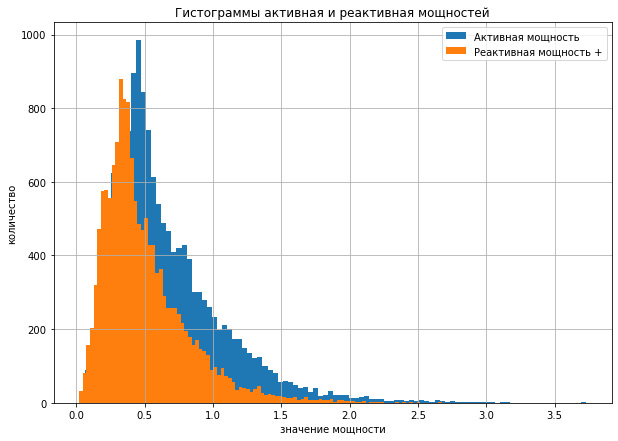

In [8]:
data_arc['Активная мощность'].hist(bins=100, figsize=(10,7), label='Активная мощность')
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100,label='Реактивная мощность +')
plt.title("Гистограммы активная и реактивная мощностей")
plt.xlabel("значение мощности")
plt.ylabel("количество")
plt.legend()

#### Вывод

В данных об элекродах содержится информация о разных итерациям обработки партий с ключом key. Пропусков в данных нет. Есть столбцы начала и конца нагрева дугой, информативнее будет рассчитать период в минутах. Реактивная можность принимает отрицательные значения, эти данные можно отнести к аномалиям. Медианы и среднее активной реактивности близки по значениям.  Выбросы оценим на следующем этапе. Данные активной и реактивной мощности распределены нормально со смещением влево.

### Данные о подаче сыпучих материалов (объём)

In [9]:
display(data_bulk.head(10))
print(data_bulk.info(),"\n")
print(data_bulk.isna().sum(axis=0),"\n")
display(data_bulk.describe())
show_rows_uniq(data_bulk)
print(len(data_bulk['key'].unique()),"\n")

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None 

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Уникальные значения столбца Bulk 2
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Уникальные значения столбца Bulk 3
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 1

#### Вывод

В данных содержится информация о разных итерациям обработки партий с ключом key. При этом на разных итерациях подаются разные сыпучие материалы. Химических элементов всего от Bulk1 до Bulk15, если значение пусто, значит данный элемент не добавили.

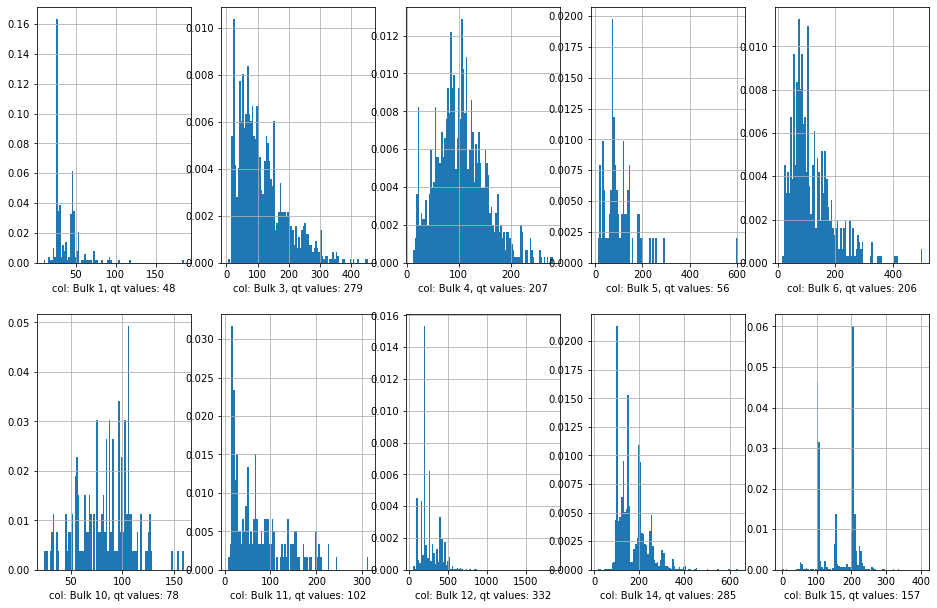

In [10]:
MIN_QT_UNIQUE = 30
fig = plt.figure()
nmb = 0
for i in range(1, 16):
    col = 'Bulk ' + str(i)
    val_cnt = len(data_bulk[col].unique())
    if  val_cnt < MIN_QT_UNIQUE:
        continue
    nmb += 1
    plt.subplot(3, 5, nmb)
    data_bulk[col].hist(bins=90, figsize=(16,16), density=True)
    plt.xlabel(f'col: {col}, qt values: {val_cnt}')


Из гистограм видно, различных хим элементов добавляли в разном количестве, сочетая друг с другом.

### Данные о подаче сыпучих материалов (время)

In [11]:
display(data_bulk_time.head(10))
print(data_bulk_time.info(),"\n")
print(data_bulk_time.isna().sum(axis=0),"\n")
display(data_bulk_time.describe())
show_rows_uniq(data_bulk_time)
print(len(data_bulk_time['key'].unique()),"\n")

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None 

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
['2019-05-03 17:50:19' '2019-05-05 10:09:13' '2019-05-05 11:01:42'
 '2019-05-05 11:59:23' '2019-05-05 13:13:45' '2019-05-05 14:17:04'
 '2019-05-05 15:03:54' '2019-05-05 16:00:33' '2019-05-05 20:49:32'
 '2019-05-07 11:24:41' '2019-05-07 15:37:52' '2019-05-07 16:15:34'
 '2019-05-07 17:35:13' '2019-05-08 01:00:11' '2019-05-08 05:26:23'
 '2019-05-08 10:05:03' '2019-05-08 10:39:56' '2019-05-08 11:33:17'
 '2019-05-08 15:14:16' '2019-05-09 04:35:17' '2019-05-10 16:46:26'
 '2019-05-10 17:16:52' '2019-05-10 18:41:05' '2019-05-10 20:05:32'
 '2019-05-11 10:46:17' '2019-05-11 12:15:55' '2019-05-11 17:50:54'
 '2019-05-12 15:36:08' '2019-05-12 16:43:26' '2019-05-12 21:33:11'
 '2019-05-13 13:14:48' '2019-05-13 14:36:57' '2019-05-14 12:01:34'
 '2019-05-14 14:09:52' '2019-05-14 16:24:02' '2019-05-14 21:58:07'
 '2019-05-15 09:27:40' '2019-05-15 15:05:04' '2019-05-15 21:42:31'
 '2019-05-15 23:52:57' '20

#### Вывод

В данных содержится дата и время подачи сыпучих материалов (Bulk1 - Bulk15) на разных итерациям обработки партий с ключом key. Информация излишния, на мой взгляд.

### Данные о продувке сплава газом

In [12]:
display(data_gas.head(10))
print(data_gas.info(),"\n")
print(data_gas.isna().sum(axis=0),"\n")
display(data_gas.describe())
show_rows_uniq(data_gas)
print(len(data_gas['key'].unique()),"\n")

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None 

key      0
Газ 1    0
dtype: int64 



,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Газ 1
[8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]
3239 



Text(0, 0.5, 'количество')

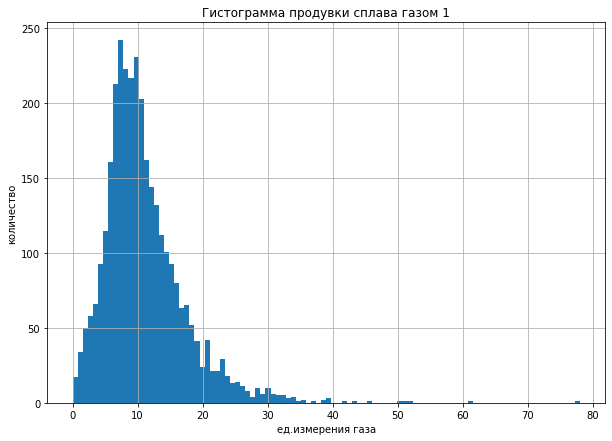

In [13]:
data_gas['Газ 1'].hist(bins=100, figsize=(10,7))
plt.title("Гистограмма продувки сплава газом 1")
plt.xlabel("ед.измерения газа")
plt.ylabel("количество")

<AxesSubplot:>

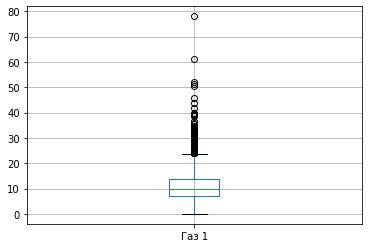

In [14]:
data_gas.boxplot(column='Газ 1')

Из гистогрммы выше видно, что выбросы находятся выше верхней границы, их немного - удалять не будем.

#### Вывод

В данных содержится информация о разных итерациям продувки сплава газом разных партий. Пропусков в данных нет. Есть столбцы начала и конца нагрева дугой, информативнее будет рассчитать период в минутах.

### Результаты измерения температуры

In [15]:
display(data_temp.head(10))
print(data_temp.info(),"\n")
print(data_temp.isna().sum(axis=0),"\n")
display(data_temp.describe())
show_rows_uniq(data_temp)
print(len(data_temp['key'].unique()),"\n")

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None 

key                0
Время замера       0
Температура     2901
dtype: int64 



,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Время замера
['2019-05-03 11:16:18' '2019-05-03 11:25:53' '2019-05-03 11:29:11' ...
 '2019-09-01 04:22:39' '2019-09-01 04:33:42' '2019-09-01 04:38:08']
Уникальные значения столбца Температура
[1191. 1204. 1208. 1218. 1227. 1383. 1519. 1520. 1525. 1526. 1527. 1528.
 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538. 1539. 1540.
 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550. 1551. 1552.
 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562. 1563. 1564.
 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574. 1575. 1576.
 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586. 1587. 1588.
 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598. 1599. 1600.
 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611. 1612.
 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623. 1624.
 1625. 1626. 1627. 1628. 1629. 1630. 1631. 1632. 1633. 

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

Text(0, 0.5, 'количество')

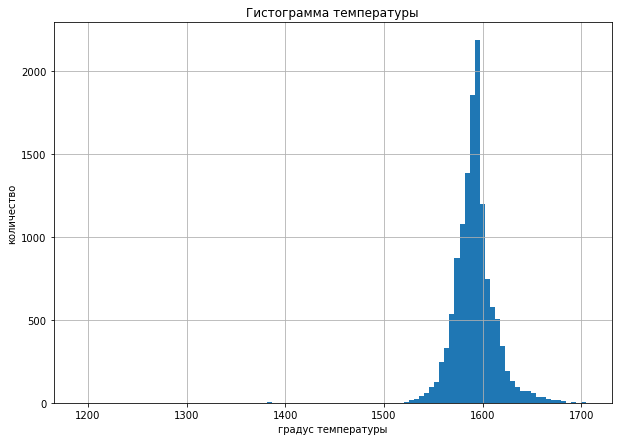

In [16]:
display(data_temp['Температура'].describe())
data_temp['Температура'].hist(bins=100, figsize=(10,7))
plt.title("Гистограмма температуры")
plt.xlabel("градус температуры")
plt.ylabel("количество")

#### Вывод

В данных содержится информация о замерах температуры на разных итерациям у разных партий. Пропуски говорят о том, что замер производили не для каждой партии. Гистограмма примает вид нормального распределения, с пиком 1590 градусов, есть аномальные значения. 

### Данные о проволочных материалах (объём)

In [17]:
display(data_wire.head(10))
print(data_wire.info(),"\n")
print(data_wire.isna().sum(axis=0),"\n")
display(data_wire.describe())
show_rows_uniq(data_wire)
print(len(data_wire['key'].unique()),"\n")

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None 

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Wire 1
[  1.9188     2.09664    3.10128  ... 280.987214 330.314424        nan]
Уникальные значения столбца Wire 2
[3.01600000e-02 6.03200000e-02 9.04800000e-02 9.04800000e-02
 1.74720000e-01 5.82400000e-01 1.17624000e+00 1.60160000e+00
 2.74456000e+00 3.98112000e+00 4.10176000e+00 4.13192000e+00
 5.12720000e+00 7.72096000e+00 8.08288000e+00 8.11304000e+00
 8.17336000e+00 8.83688000e+00 9.01784000e+00 9.04800000e+00
 9.07816000e+00 9.08544100e+00 9.10832000e+00 9.11456000e+00
 9.13848000e+00 9.14368100e+00 9.16864000e+00 9.19880000e+00
 9.22896000e+00 9.31944000e+00 9.68136000e+00 1.00432800e+01
 1.00734400e+01 1.01036000e+01 1.01337590e+01 1.01337600e+01
 1.01639190e+01 1.01940790e+01 1.02242400e+01 1.10385600e+01
 1.10687200e+01 1.10988800e+01 1.11238400e+01 1.11290400e+01
 1.11592000e+01 1.11893600e+01 1.12195200e+01 1.20338400e+01
 1.20848000e+01 1.20941600e+01 1.21243200e+01 1.21430400e+

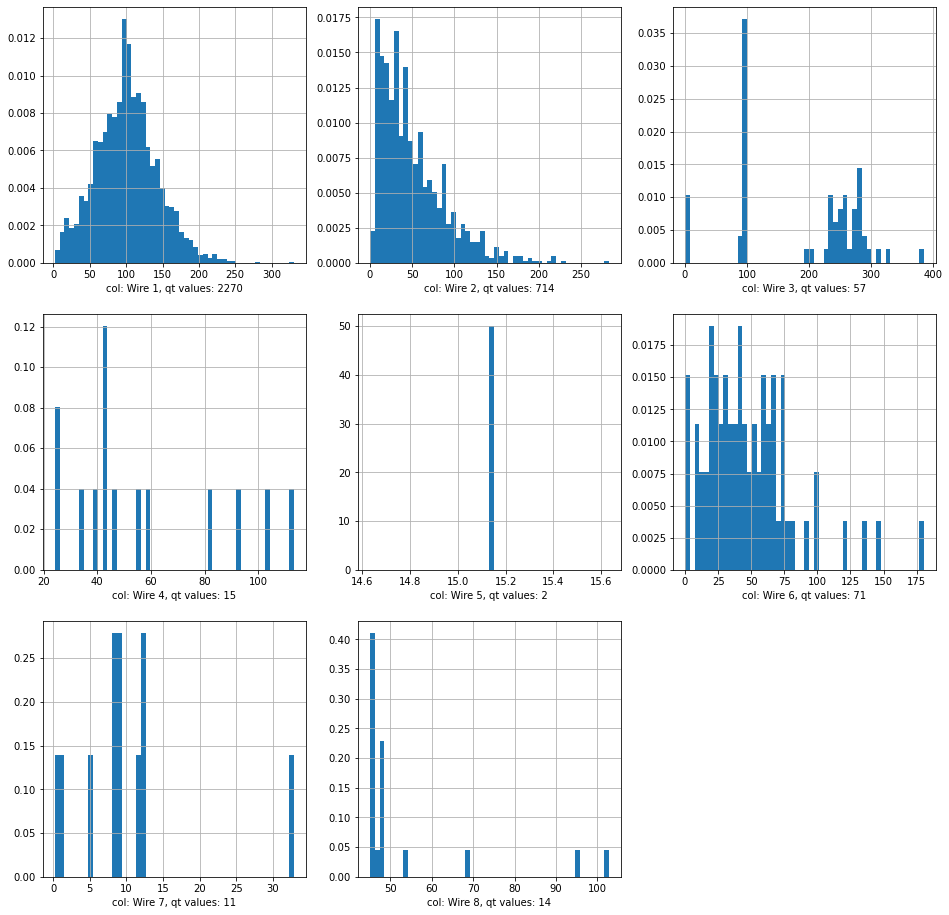

In [18]:
fig = plt.figure()
nmb = 0
for i in range(1, 9):
    col = 'Wire ' + str(i)
    val_cnt = len(data_wire[col].unique()) 
    nmb += 1
    plt.subplot(3,3, nmb)
    data_wire[col].hist(bins=50, figsize=(16,16), density=True)
    plt.xlabel(f'col: {col}, qt values: {val_cnt}')

Есть пропуски, потому что различные виды проволочных материалов поступали в разных пропорциях в разные промежутки времени.

#### Вывод

В данных содержится информация о разных итерациям обработки партий с ключом key. При этом на разных итерациях подаются разные проволочные материалы. Материалов всего от Wire 1 до Wire 9, если значение пусто, значит данный материал не подавали.

### 1.7 Данные о проволочных материалах (время)

In [19]:
display(data_wire_time.head(10))
print(data_wire_time.info(),"\n")
print(data_wire_time.isna().sum(axis=0),"\n")
display(data_wire_time.describe())
show_rows_uniq(data_wire_time)
print(len(data_wire_time['key'].unique()),"\n")

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None 

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64 



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Wire 1
['2019-05-03 11:11:41' '2019-05-03 11:46:10' '2019-05-03 12:13:47' ...
 '2019-09-01 03:12:02' '2019-09-01 04:16:01' nan]
Уникальные значения столбца Wire 2
['2019-05-03 13:32:06' '2019-05-03 13:59:54' '2019-05-03 15:58:12' ...
 '2019-08-31 13:14:22' '2019-08-31 18:50:15' nan]
Уникальные значения столбца Wire 3
['2019-05-04 04:47:53' '2019-05-04 05:40:08' '2019-05-07 08:50:29'
 '2019-05-07 10:17:14' '2019-05-07 15:50:31' '2019-05-07 16:34:12'
 '2019-05-07 17:43:23' '2019-05-07 21:58:49' '2019-05-07 22:40:07'
 '2019-05-07 23:27:46' '2019-05-18 13:04:48' '2019-05-18 13:41:36'
 '2019-05-18 20:52:18' '2019-05-18 21:49:12' '2019-06-02 20:37:44'
 '2019-06-08 16:23:31' '2019-06-10 13:19:54' '2019-06-10 14:05:33'
 '2019-06-10 14:25:42' '2019-06-12 01:29:02' '2019-06-12 20:11:25'
 '2019-06-12 21:27:01' '2019-07-07 18:33:17' '2019-07-07 19:25:35'
 '2019-07-07 20:16:17' '2019-07-08 17:20:59' '201

#### Вывод

В данных содержится дата и время подачи проволочных материалов (Wire 1 - Wire 9) на разных итерациям обработки партий с ключом key. Информация излишния, на мой взгляд.

### Выводы

Проанализиров данные, отметим:

- таблицы data_arc и data_temp обладают записями с одинаковыми значениями key в разное время применения технологической операции. Количество записей у одной партии для каждой таблицы может различаться;
- несоответсвующий тип данных (есть столбцы, которые могут не использовать тип float, так как хранят только целые числа; преобразование в datetime);
- пропуски значений в столбцах (возможно это ошибка датчика, который не передал информацию или отсутствие действия/замера на этой стадии). 

Данные требуют предобработки и группировки по признаку key.

## Предобработка данных

Шаги предобработки:

1. Найти общее время нагрева дугой, суммы значений активной и реактивной мощности
2. Найти все записи по температурам, где есть минимум два значения температуры первого и последнего замера. 
3. Заменить nan на 0 для таблиц data_bulk и data_wire.
4. Приведем типы данных для ускорения работы.
5. Объеденим данные, приготовим признаки.
5. Разбиение на обучающую и тестовую выборки 80/20.

### Таблица data_arc

In [20]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
#Создадим новый признак "Общее время нагрева дугой", переведем в секунды
data_arc['Общее время нагрева дугой'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Общее время нагрева дугой'] = data_arc['Общее время нагрева дугой'].dt.seconds
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   key                        14876 non-null  int64         
 1   Начало нагрева дугой       14876 non-null  datetime64[ns]
 2   Конец нагрева дугой        14876 non-null  datetime64[ns]
 3   Активная мощность          14876 non-null  float64       
 4   Реактивная мощность        14876 non-null  float64       
 5   Общее время нагрева дугой  14876 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 697.4 KB


In [21]:
print("Количество выбросов:",len(data_arc[data_arc['Реактивная мощность'] <= 0]))
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

Количество выбросов: 1


Имея данные по активной и реактивной мощности можем ввести новый признак "Полная мощность" по следующей формуле:

$$ S=\sqrt{P^2+Q^2} $$
где: $P$ — активная мощность, $Q$ — реактивная мощность

In [22]:
#Функция по расчету Полной мощности
def full_power(row):
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [23]:
data_arc['Полная мощность'] = data_arc.apply(full_power, axis=1)

<AxesSubplot:>

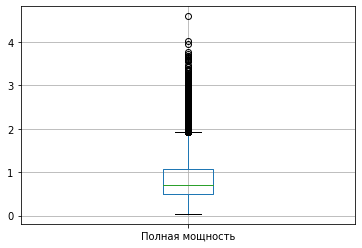

In [24]:
data_arc.boxplot(column='Полная мощность')

Из данного графика видно, что медианное значение сдвинуто влево, выбросов не много, поэтому оставим их.

### Таблицы data_bulk и data_wire

In [25]:
#Изменим тип на целый для сыпухих материалов
for i in range(1,16):
    data_bulk[f'Bulk {i}'] = pd.to_numeric(data_bulk[f'Bulk {i}'], downcast='integer')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [26]:
#Заменим пропуски на 0
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [27]:
# Найдем общее количество добавлений для каждой партии

data_bulk['sum_bulk'] = data_bulk.iloc[:,1:].sum(axis = 1)
data_wire['sum_wire'] = data_wire.iloc[:,1:].sum(axis = 1)

display(data_bulk)
display(data_wire)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400


### Таблица data_temp

In [28]:
#Изменим тип данных у время замера
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [29]:
data_temp[data_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


In [30]:
data_temp[data_temp['Температура'].isnull()].tail()

,key,Время замера,Температура
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


Начиная с 2500 партии наблюдаем пропущенные значения.

По справочнику она у металла = около 1400. Поэтому аномальные значения можно удалить:

In [31]:
print("Количество выбросов:",len(data_temp[data_temp['Температура'] <= 1400]))
data_temp = data_temp[data_temp['Температура'] >= 1400]

Количество выбросов: 7


### Объединение данных

In [32]:
# Поcле 2500 партии значения температуры есть только для первого измерения. 
# Поэтому будем использовать только партии до 2500 номера.
data_temp = data_temp.query('key < 2500')
data_arc = data_arc.query('key < 2500')
data_bulk = data_bulk.query('key < 2500')
data_wire = data_wire.query('key < 2500')

In [33]:
# определим количество итераций нагрева
data_arc_c = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
data_arc_c.columns = ['key', 'Количество итераций нагрева']

In [34]:
# сгруппируем данные по партиям
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

# добавим информацию о количестве итераций нагрева по ключу key
data_arc = data_arc.merge(data_arc_c, how = 'left', on = 'key')

In [35]:
data_arc = data_arc[['key', 'Полная мощность', 'Общее время нагрева дугой', 'Количество итераций нагрева']]
data_arc.head(5)

,key,Полная мощность,Общее время нагрева дугой,Количество итераций нагрева
0,1,5.826395,1098,5
1,2,3.649216,811,4
2,3,2.989534,655,5
3,4,3.814962,741,4
4,5,4.035758,869,4


,Полная мощность,Общее время нагрева дугой,Количество итераций нагрева
Полная мощность,1.000000,0.982899,0.760402
Общее время нагрева дугой,0.982899,1.000000,0.795958
Количество итераций нагрева,0.760402,0.795958,1.000000


<Figure size 1080x720 with 0 Axes>

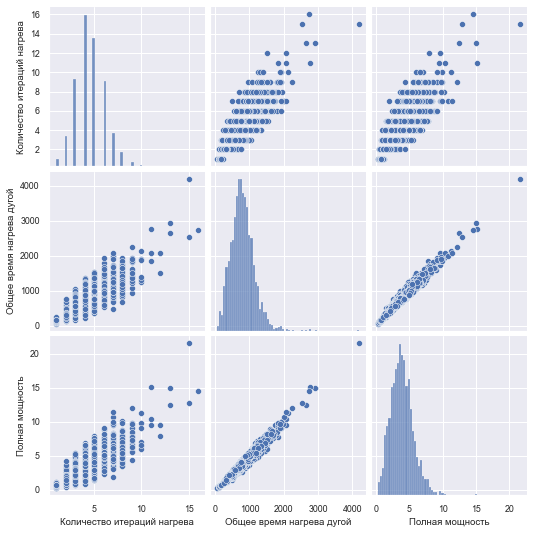

In [36]:
#Посмотрим на корреляцию имеющихся признаков
display(data_arc[['Полная мощность', 'Общее время нагрева дугой', 'Количество итераций нагрева']].corr())
plt.figure(figsize=(15,10))
sns.set(font_scale=0.8)
sns.pairplot(data_arc[['Количество итераций нагрева', 'Общее время нагрева дугой', 'Полная мощность']], 
             kind="scatter")
plt.show();

Сильная корреляция между полной мощностью и общим временем нагрева дугой, удалим признак времени.

In [37]:
data_arc = data_arc[['key', 'Полная мощность', 'Количество итераций нагрева']]
data_arc.head(10)

,key,Полная мощность,Количество итераций нагрева
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4
5,6,4.786837,4
6,7,2.987777,4
7,8,4.627389,4
8,9,2.555348,5
9,10,3.851739,6


Удалим пропуски в данных в таблице data_temp:

In [38]:
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)
data_temp = data_temp.sort_values(by=['Время замера'])

In [39]:
#Удалим информацию о партиях по которым известно только одно измерение температуры.
count = data_temp.groupby(by = 'key', as_index = False).count()
one = count[count['Время замера'] == 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

Сгруппируем данные по партии по первым и последним значениям, последние значения необходимо будет предсказывать:

In [40]:
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Время замера 1', 'Время замера 2', 'Температура 1', 'Температура 2']
data_temp = data_temp[['key', 'Температура 1', 'Температура 2']]
data_temp.head(10)

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


Объединим обработанные датасеты по ключу key:

In [41]:
data = (data_temp.merge(data_arc, how = 'inner', on = 'key')
                 .merge(data_wire, how = 'inner', on = 'key')
                 .merge(data_bulk, how = 'inner', on = 'key')
                 .merge(data_gas, how = 'inner', on = 'key')
       )

In [42]:
data

,key,Температура 1,Температура 2,Полная мощность,Количество итераций нагрева,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Газ 1
0,1,1571.0,1613.0,5.826395,5,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,1581.0,1602.0,3.649216,4,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,1596.0,1599.0,2.989534,5,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,1601.0,1625.0,3.814962,4,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,1576.0,1602.0,4.035758,4,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.986869,4,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,7.125735
2325,2496,1554.0,1591.0,5.057033,6,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,9.412616
2326,2497,1571.0,1589.0,2.885017,3,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,6.271699
2327,2498,1591.0,1594.0,4.143749,5,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,733.0,14.953657


In [43]:
# заполним пропуски образовавшиеся после объединения таблиц нулями
data = data.fillna(0)

In [44]:
data.columns

Index(['key', 'Температура 1', 'Температура 2', 'Полная мощность',
       'Количество итераций нагрева', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'sum_wire', 'Bulk 1',
       'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8',
       'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',
       'Bulk 15', 'sum_bulk', 'Газ 1'],
      dtype='object')

Переименуем столбцы:

In [45]:
data = data.rename(columns={'Температура 1': 'First_temp',
                            'Температура 2': 'Last_temp',
                            'Полная мощность': 'Full_power',
                            'Количество итераций нагрева':'Heating_iterations',
                            'Газ 1': 'Gas'})


In [46]:
# уберем колонку-индентификатор key
data = data.drop(['key'], axis = 1)

Получили датафрейм:

In [47]:
display(data.head(5))
data.info()

,First_temp,Last_temp,Full_power,Heating_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Gas
0,1571.0,1613.0,5.826395,5,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,1581.0,1602.0,3.649216,4,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,1596.0,1599.0,2.989534,5,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,1601.0,1625.0,3.814962,4,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,1576.0,1602.0,4.035758,4,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   First_temp          2329 non-null   float64
 1   Last_temp           2329 non-null   float64
 2   Full_power          2329 non-null   float64
 3   Heating_iterations  2329 non-null   int64  
 4   Wire 1              2329 non-null   float64
 5   Wire 2              2329 non-null   float64
 6   Wire 3              2329 non-null   float64
 7   Wire 4              2329 non-null   float64
 8   Wire 5              2329 non-null   float64
 9   Wire 6              2329 non-null   float64
 10  Wire 7              2329 non-null   float64
 11  Wire 8              2329 non-null   float64
 12  Wire 9              2329 non-null   float64
 13  sum_wire            2329 non-null   float64
 14  Bulk 1              2329 non-null   float64
 15  Bulk 2              2329 non-null   float64
 16  Bulk 3

In [48]:
data[(data['sum_wire']<=0) | (data['sum_bulk']<=0) | (data['Gas']<=0)]


,First_temp,Last_temp,Full_power,Heating_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Gas


### Оценку мультиколлинеарности

Сформированный датафрейм проверим на мультиколлинеарность:

In [49]:
data_corr =data.corr()
data_corr

,First_temp,Last_temp,Full_power,Heating_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Gas
First_temp,1.000000,0.301320,-0.429306,-0.178086,0.262598,-0.100733,-0.003485,0.076022,NaN,0.020635,...,-0.011748,-0.033421,0.035584,-0.110481,-0.080115,0.020167,-0.181076,-0.063041,-0.112063,0.036047
Last_temp,0.301320,1.000000,0.273558,0.181146,0.317575,-0.206672,-0.047537,-0.159719,NaN,-0.084034,...,-0.026587,-0.016075,0.061350,-0.114753,0.267424,-0.010920,0.114617,0.266414,0.222658,0.059160
Full_power,-0.429306,0.273558,1.000000,0.765932,0.037996,0.054297,0.034025,0.059216,NaN,0.054648,...,-0.010434,0.019432,0.001905,0.073919,0.473637,0.120982,0.455825,0.322061,0.559714,0.370528
Heating_iterations,-0.178086,0.181146,0.765932,1.000000,0.138280,0.078237,0.055277,0.113648,NaN,0.053402,...,-0.008968,0.038237,0.012722,0.062603,0.307230,0.117718,0.333906,0.175047,0.415996,0.403947
Wire 1,0.262598,0.317575,0.037996,0.138280,1.000000,-0.068301,0.038075,-0.142005,NaN,-0.128036,...,0.034650,0.022596,0.062713,-0.117755,0.170167,0.039439,-0.053835,0.118437,0.108786,0.117313
Wire 2,-0.100733,-0.206672,0.054297,0.078237,-0.068301,1.000000,0.094073,-0.033758,NaN,-0.058700,...,0.018912,0.066733,-0.103758,0.062067,-0.098263,-0.001390,0.036309,-0.096415,-0.067053,0.104248
Wire 3,-0.003485,-0.047537,0.034025,0.055277,0.038075,0.094073,1.000000,0.169810,NaN,0.183456,...,-0.002400,-0.008282,-0.027977,-0.021829,-0.120469,-0.008685,-0.008859,-0.118076,-0.085001,0.103382
Wire 4,0.076022,-0.159719,0.059216,0.113648,-0.142005,-0.033758,0.169810,1.000000,NaN,0.445960,...,-0.001336,-0.004609,-0.015571,-0.012153,-0.085535,-0.004833,-0.121828,-0.091352,0.033046,0.145413
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.020635,-0.084034,0.054648,0.053402,-0.128036,-0.058700,0.183456,0.445960,NaN,1.000000,...,-0.002334,-0.008055,-0.017800,0.008701,-0.042731,-0.008447,-0.052387,-0.032421,0.054789,0.108089


<AxesSubplot:>

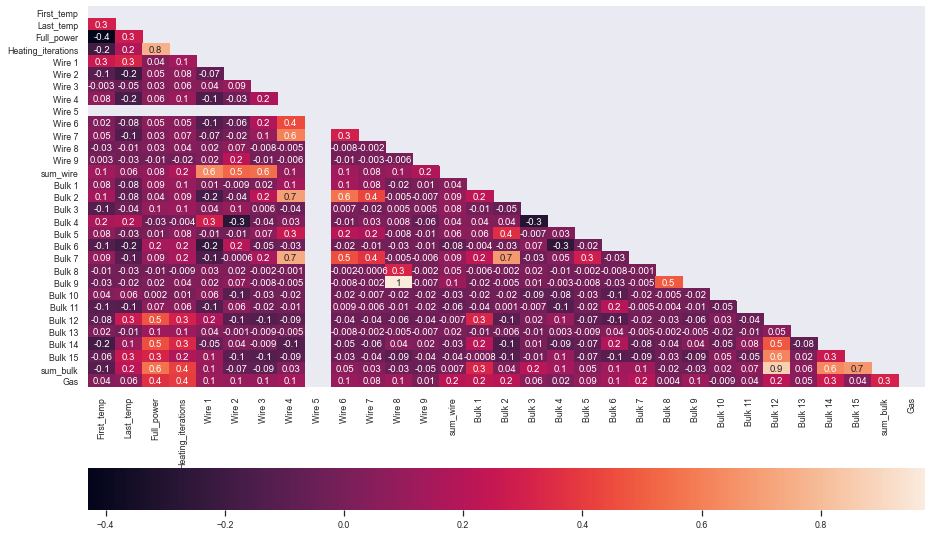

In [52]:
plt.figure(figsize = (15,10))
matrix = np.triu(data_corr)
sns.heatmap(data_corr, annot = True, fmt='.1g', cbar_kws= {'orientation': 'horizontal'}, mask=matrix)

Из heatmap видно :
- `Wire 5` пустой столбец;
- есть сильные прямопропоциональные зависимости между признакаи  - `Bulk 9` и `Wire 8`, `sum_bulk`и  `Bulk 12`.

Так как они дублируют друг друга, удалим из обучения `Wire 8` и `Bulk 12`, `Wire 5` - неинформативный.

In [54]:
data = data.drop(['Bulk 12', 'Wire 8', 'Wire 5'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   First_temp          2329 non-null   float64
 1   Last_temp           2329 non-null   float64
 2   Full_power          2329 non-null   float64
 3   Heating_iterations  2329 non-null   int64  
 4   Wire 1              2329 non-null   float64
 5   Wire 2              2329 non-null   float64
 6   Wire 3              2329 non-null   float64
 7   Wire 4              2329 non-null   float64
 8   Wire 6              2329 non-null   float64
 9   Wire 7              2329 non-null   float64
 10  Wire 9              2329 non-null   float64
 11  sum_wire            2329 non-null   float64
 12  Bulk 1              2329 non-null   float64
 13  Bulk 2              2329 non-null   float64
 14  Bulk 3              2329 non-null   float64
 15  Bulk 4              2329 non-null   float64
 16  Bulk 5

### Разбиение на обучающую и тестовую выборки

Выделим из исходного датафрейма вектор признаков df_x (признаки для обучения) и целевой вектор df_y (цель для обучения):

In [55]:
random_state = 29082022
train, test = train_test_split(data, test_size = .20, random_state = random_state)
x_df = data.drop('Last_temp', axis=1)
y_df = data['Last_temp']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.8, random_state = 29082022)
print("Размер обучающей выборки: {0}; целевой признак {1}:".format(X_train.shape,y_train.shape))
print("Размер валидационной выборки: {0}; целевой признак {1}:".format(X_test.shape,y_test.shape)) 

Размер обучающей выборки: (1863, 27); целевой признак (1863,):
Размер валидационной выборки: (466, 27); целевой признак (466,):


### Масштабирование признаков

Для численных столбцов необходимо провести стандартизацию данных:

In [57]:
numeric = X_train.columns
numeric

Index(['First_temp', 'Full_power', 'Heating_iterations', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 9', 'sum_wire', 'Bulk 1',
       'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8',
       'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13', 'Bulk 14', 'Bulk 15',
       'sum_bulk', 'Gas'],
      dtype='object')

In [58]:
scaler = MinMaxScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_train

,First_temp,Full_power,Heating_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 13,Bulk 14,Bulk 15,sum_bulk,Gas
98,0.751773,0.210683,0.333333,0.000000,0.000000,0.241732,0.0,0.149487,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.167289,0.648478
2279,0.347518,0.198376,0.133333,0.235251,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.025559,0.0,0.182390,0.607407,0.228856,0.111822
589,0.290780,0.243299,0.133333,0.391187,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.314465,0.256790,0.160759,0.135332
2056,0.333333,0.223994,0.133333,0.506073,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.292453,0.451852,0.269279,0.104754
2301,0.765957,0.120686,0.133333,0.348314,0.406997,0.000000,0.0,0.000000,0.0,0.183099,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.251572,0.506173,0.187811,0.125713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,0.255319,0.218282,0.133333,0.051705,0.046715,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.147799,0.000000,0.226368,0.010964
415,0.517730,0.221789,0.266667,0.395579,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.238994,0.377778,0.194652,0.149154
2194,0.567376,0.376356,0.466667,0.249003,0.149851,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.217252,0.0,0.388365,0.390123,0.251244,0.212597
251,0.482270,0.236443,0.333333,0.378861,0.124294,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.482993,0.000000,0.000000,0.0,0.402516,0.000000,0.153918,0.232846


### Вывод

На данном этапе данные готовы к моделированию:
- удалили от выборосы, заменили пропуски;
- добавили новые признаки;
- объеденили данные;
- разбили на обучающую и тестовую выборки;
- смаштабировали признаков.

## Обучение моделей

Обучим следующие модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

В качестве метрики примим MAE. Количество кросс-валидаций равным 5.

In [59]:
cv_counts = 5

### LinearRegression

In [60]:
%%time

regressor = LinearRegression()
regressor.fit(X_train, y_train)
cv_MAE_LR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression = {:.7f}'.format(cv_MAE_LR))



Mean MAE from CV of LinearRegression = 6.1613981
Wall time: 106 ms


### RandomForestRegressor

In [61]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[random_state]}]

print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(X_train, y_train)

best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)


{'criterion': 'mse', 'n_estimators': 400, 'random_state': 29082022}

Grid scores on development set:

6.172141 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 29082022}
6.163610 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 29082022}
6.169349 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 29082022}
6.160844 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 29082022}
6.155765 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 29082022}
6.152961 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 29082022}
6.145797 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 29082022}
6.147079 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 29082022}
6.150006 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 29082022}
6.155382 for {'criterion': 'mse', 'n_estimators': 550, 'random_state': 29082022}
6.152069 for {'criterion': 'mse', 'n_estimators': 600, 'random_state': 29082022}
6.1545

### CatBoostRegressor

In [62]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)

print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)


Mean MAE from CV of CatBoostRegressor = 6.073638119341107
Wall time: 19.5 s


In [63]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(X_train, 
                                        y_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 29082022,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04517199844121933,
 'score_function': 'Cosine',
 'tas

### LGBMRegressor

In [64]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,31)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[random_state]}]

print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)


Best parameters set found on development set:

{'learning_rate': 0.06, 'num_leaves': 22, 'random_state': 29082022}

Grid scores on development set:

7.016408 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 29082022}
6.984935 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 29082022}
6.949598 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 29082022}
6.916123 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 29082022}
6.901684 for {'learning_rate': 0.01, 'num_leaves': 14, 'random_state': 29082022}
6.882114 for {'learning_rate': 0.01, 'num_leaves': 15, 'random_state': 29082022}
6.861903 for {'learning_rate': 0.01, 'num_leaves': 16, 'random_state': 29082022}
6.843353 for {'learning_rate': 0.01, 'num_leaves': 17, 'random_state': 29082022}
6.821687 for {'learning_rate': 0.01, 'num_leaves': 18, 'random_state': 29082022}
6.802752 for {'learning_rate': 0.01, 'num_leaves': 19, 'random_state': 29082022}
6.782211 for {'learning_rate': 0.01, 'nu

### XGBRegressor

In [65]:
%%time

regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[random_state],
                 'silent':[True]}]

print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)


[12:55:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:55:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:55:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a fals

### Вывод

Сформируем сводную таблицы метрик для всех моделей:

In [66]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR]
       }

scores_data = pd.DataFrame(data=data, index=index)
scores_data.sort_values(by = 'MAE на CV')

,MAE на CV
LGBMRegressor,6.061894
CatBoostRegressor,6.073638
XGBRegressor,6.078954
RandomForestRegressor,6.145797
LinearRegression,6.161398


Были выбраны и обучены несколько моделей для предсказания финальной температуры. 
Сравнив результаты MAE на кросс-валидацию, получили, что модель LGBMRegressor прогнозирует лучше. Модели  CatBoostRegressor	и XGBRegressor близки по метрикам, наихудший результат у LinearRegression.

Выполним тестироавние LGBMRegressor модели.

## Тестирование модели

In [67]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(X_train, y_train)
target_predict = model.predict(X_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, y_test)
print('MAE on test of LGBMRegressor =', test_MAE_LGBMR)

MAE on test of LGBMRegressor = 5.926710096293588
Wall time: 166 ms


Итоговые результаты LGBMRegressor:  
- качество предсказания MAE: 5.927

### Feature Importance

Важность факторов для модели :

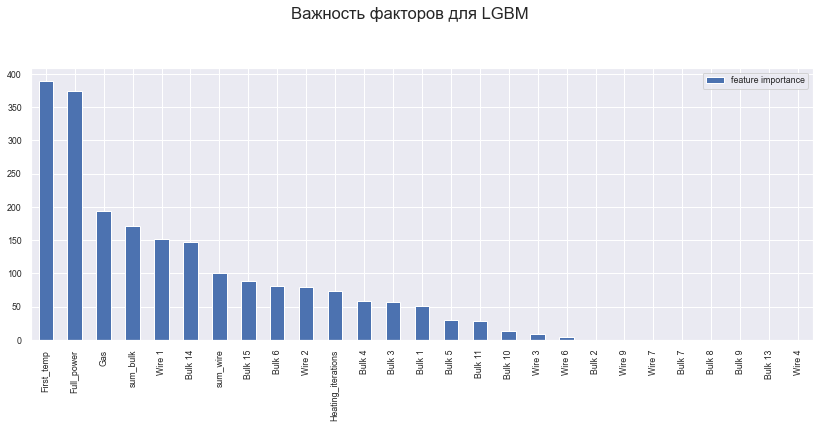

In [69]:
df_feature_importance = pd.DataFrame(model.feature_importances_, index=X_test.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

df_feature_importance.plot(kind='bar', grid = True, figsize=(14, 5))
plt.suptitle('Важность факторов для LGBM', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

Из графика видно, что для модели LGBMRegressor важны признаки:
- начальная температура;
- полная мощность;
- подаваемый инертный газ. 

## Отчёт по решению

Общий вывод

В данном проекте была найдена лучшая регрессионная модель для расчета температуры стали для  металлургического комбината ООО «Так закаляем сталь».

На этапе обзора рассмотрели первоначальные данные, оценили визуально, определили не нужные таблицы и наметили план действий. 

В ходе предобработки данных были:
- приведены типы данных;
- удалены аномальные значения;
- добавлены новые признаки;
- оценена мультиколлинеарность;
- сформиррован датафрейм для моделирования;
- количественные признаки стандартизировали при помощи MinMaxScaler;
- разделили на обучающию и тестовую выборки (80/20).

Было реализовано 5 моделей:

- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

Для каждой модели провели подбор гиперпараметров с помощью GridSearchCV.
Лучший результат на кросс-валидации показала модель LGBMRegressor, для которой было выполнено тестирование с результатом MAE: 5.927. Выявили признаки, которые больше всего влияют на модель: начальная температура, полная мощность, подаваемый инертный газ.

**Рекомендую к использованию модель LGBMRegressor, так как продемонстрировала лучший результат предсказания.**